# Mini Lab

## Brett Hallum, Mridul Jain, and Solomon Ndungu

We start this lab by filtering out our unwanted data. A lot of this information was removed in Lab 1 as it did not make sense for us to use it due to missing values, single values for whole set, and a minimal distribution of values. On top of this removal, we do some imputation to fill in minor missing data values. Finally, we do some nominal classification on some of our data to order it for better use.

We do create two additional data frames, loan_df_finished and loan_df_unfinished, at this point as well. Their purpose and usage will be discussed shortly.

In [1]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee','last_pymnt_d',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'installment', 'mths_since_last_major_derog', 'desc',
           'issue_d', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt', 'out_prncp']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='Grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data (used for new data frames)
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

#Impute missing data values with median
for col in ['total_acc']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp    

    
tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1)

if 'purpose' in loan_df:
    del loan_df['purpose']    
    
# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans


loan_df.copy()

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]

print loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 52 columns):
funded_amnt                        887379 non-null int64
term                               887379 non-null int64
annual_inc                         887379 non-null float64
dti                                887379 non-null float64
delinq_2yrs                        887379 non-null float64
inq_last_6mths                     887379 non-null float64
open_acc                           887379 non-null float64
total_acc                          887379 non-null float64
total_pymnt                        887379 non-null float64
acc_now_delinq                     887379 non-null float64
Grade_A                            887379 non-null float64
Grade_B                            887379 non-null float64
Grade_C                            887379 non-null float64
Grade_D                            887379 non-null float64
Grade_E                            887379 non-null float64
Grade_F 

In [2]:
from sklearn.cross_validation import ShuffleSplit

# Split our data frame into our classification of Loan_Class and the rest of the data set
if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values

# Shuffle split our data into an 80/20 breakdown. The 80 will be used for training and the 20 for testing
num_cv_iterations = 5
num_instances = len(y)
cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print cv_obj

ShuffleSplit(887379, n_iter=5, test_size=0.2, random_state=None)


### Logistic Regression

We will begin by conducting a logistic regression on the full data set. We will look at the accuracy of the classification to see how accurate the regression model is and the confusion matrix to see if there are any oddities in the breakdown.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

# Fit and test the regression model for each shuffled instance
for iter_num, (train_indices, test_indices) in enumerate(cv_obj):
    logreg_obj.fit(X[train_indices],y[train_indices])  # train object
    y_hat = logreg_obj.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(y[test_indices],y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)

====Iteration 0  ====
accuracy 0.932097861119
confusion matrix
[[     0  12051]
 [     0 165425]]
====Iteration 1  ====
accuracy 0.931123081431
confusion matrix
[[     0  12224]
 [     0 165252]]
====Iteration 2  ====
accuracy 0.931280849242
confusion matrix
[[     0  12196]
 [     0 165280]]
====Iteration 3  ====
accuracy 0.9313991751
confusion matrix
[[     0  12175]
 [     0 165301]]
====Iteration 4  ====
accuracy 0.93156821204
confusion matrix
[[     0  12145]
 [     0 165331]]


Looking at the accuracy of this logistic regression, sitting around 93.1% on average, it seems like it does a decent job of sorting the groups. However, if we look at the confusion matrix, all of the "Bad" classifications of the loans are getting classified as "Good". This most likely  because our data is skewed. We have data that has been through the full process of the loan and has been determined to be either good, meaning the loan is complete, or bad, meaning the loan went into default and the company has written it off. The rest of our data, which is a good portion of it, are loans that are still current, or in the process of going through the full life cycle. Some of these loans could still go into default, but we do not know if they will or not.

To handle this in our classification, we split our data up. We created a data frame of finished loans (loan_df_finished) to clarify those that have been completed and a data frame of current loans (loan_df_unfinished) to specify those that have not finished their life cycle. We will use the finished loans data frame to try to classify our data better. The unfinished data frame can then be used later for cross validation.

In [4]:
# Add column to determine if loan is good or bad based on classification in data set
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)

#Remove Loan_Class and Loan_Class2 from the data frame so they are no longer observed for classification
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]

In [5]:
# Split the data into our x and y matrices for testing
if 'isGoodLoan' in loan_df_finished:
    updated_y = loan_df_finished['isGoodLoan'].values
    del loan_df_finished['isGoodLoan']
    updated_X = loan_df_finished.values

# Create a new Shuffle split on the narrowed classification data
num_cv_iterations = 5
num_instances = len(updated_y)
updated_cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

In [6]:
updated_logreg_obj = LogisticRegression(penalty='l2', C=10, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "==== Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

==== Iteration 0  ====
accuracy 0.97877367197
confusion matrix
[[11220  1053]
 [   97 41808]]
==== Iteration 1  ====
accuracy 0.980231828417
confusion matrix
[[11276   975]
 [   96 41831]]
==== Iteration 2  ====
accuracy 0.979456606002
confusion matrix
[[11122  1021]
 [   92 41943]]
==== Iteration 3  ====
accuracy 0.980785558714
confusion matrix
[[11328   970]
 [   71 41809]]
==== Iteration 4  ====
accuracy 0.979659640444
confusion matrix
[[11301  1028]
 [   74 41775]]


The results of this classification not only have a higher accuracy than the original, full data set, right around 97.9% on average rather than 93.1%, but it also has better looking confusion mattrices. There are data points that are classified correctly. Although there are still a large number of bad loans being incorrectly identified as good, it is much better distributed than the original set.

We follow up this analysis by looking at the weight of each factor used. This will help us figure out if there are certain features that are more influential than others to help with the classification of each point.

In [7]:
from sklearn.preprocessing import StandardScaler

# Non-normalized weights
# Iterate over the coefficients to get the weight for each variable
weights = updated_logreg_obj.coef_.T # take transpose to make a column vector
variable_names = loan_df_finished.columns
for coef, name in zip(weights,variable_names):
    print name, 'has weight of', coef[0]

funded_amnt has weight of -0.00177285410842
term has weight of 0.0109146618133
annual_inc has weight of 1.8946756668e-05
dti has weight of 0.0052627610702
delinq_2yrs has weight of 2.37930783409e-05
inq_last_6mths has weight of 4.55739811583e-05
open_acc has weight of 0.00277159845926
total_acc has weight of 0.00699079252871
total_pymnt has weight of 0.00177494043552
acc_now_delinq has weight of 8.19858668353e-07
Grade_A has weight of 0.000219614227373
Grade_B has weight of 0.000150861574597
Grade_C has weight of 7.14502576707e-05
Grade_D has weight of -4.59385001302e-05
Grade_E has weight of -3.32457740465e-05
Grade_F has weight of -2.07550442776e-05
Grade_G has weight of -5.79121453494e-06
Employ_1 year has weight of 3.07831949817e-05
Employ_10+ years has weight of 5.81175141655e-05
Employ_2 years has weight of 4.12492029553e-05
Employ_3 years has weight of 3.43657615383e-05
Employ_4 years has weight of 2.24786639615e-05
Employ_5 years has weight of 1.34096634701e-05
Employ_6 years h

We want to normalize the weights for each variable so that a much larger valued variable, such as the funded amount, is weighted the same as a small valued variable such as one that is binary or nominal.

In [8]:
warnings.simplefilter("ignore")

# Normalize the features
scale_obj = StandardScaler()
scale_obj.fit(updated_X[train_indices])

X_train_scaled = scale_obj.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scale_obj.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf

# Sort the attributes on size and print them out in order of weight
zip_vars = zip(updated_logreg_obj.coef_.T,loan_df_finished.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef[0] # now print them out

accuracy: 0.979068994795
[[11268  1061]
 [   73 41776]]
Employ_4 years has weight of -0.00122583216766
Loan_Purpose_major_purchase has weight of 0.00671722129654
Loan_Purpose_renewable_energy has weight of -0.00682041184755
Employ_1 year has weight of 0.00777810090257
delinq_2yrs has weight of -0.00819093294133
Loan_Purpose_moving has weight of -0.00846380242233
Employ_6 years has weight of -0.00983433944793
Loan_Purpose_home_improvement has weight of -0.0106744815443
Loan_Purpose_vacation has weight of -0.010936642916
Loan_Purpose_car has weight of -0.0113012331651
Loan_Purpose_medical has weight of -0.0151245160702
Employ_7 years has weight of -0.0153491169904
Employ_2 years has weight of 0.0154807822878
Employ_10+ years has weight of 0.0163071617475
Loan_Purpose_house has weight of 0.0174461601917
Home_ANY has weight of 0.0176907900634
Home_NONE has weight of -0.020378711342
Employ_9 years has weight of -0.0204113874089
Employ_3 years has weight of 0.0210280872402
Home_OWN has weigh

After scaling the data, we still get a similar accuracy to before and our confusion matrix has remained proportional. The scaled view of the variables provides a better way to compare each of the variables to one another and see which have a significant impact. In the graph below, it is even easier to note which variables have the most impact. The funded amount and total payment variables have a significant impact over any of the rest of the variables. Other notable variables that are valued slightly higher than the other factors are the Interst Rate Range, annual income and the number of total accounts someone has.

These values make a lot of sense as to why they are the most important. The total payment should definitely be a factor that plays into determining if a loan is good or bad. If the loan is in good standing, the full principle amount will be paid off. This will relate positively because as you pay more back to the bank, you will become closer to finishing the loan. Alternatively, the less money you have paid the more likely you are to default on the loan. Funded amount and interest rate range are also valuable. Banks probably use these in relation to one another to determine who will default and give certain rates for ceratin funded amounts. They are negatively weighted in this case which means the higher the interest rate and the higher the funded amount, the more likely someone is to default. As a loan increases in value and interest rate, it gets more difficult to pay off the loan and so someone is more likely to go into default and end up with a "bad" loan.

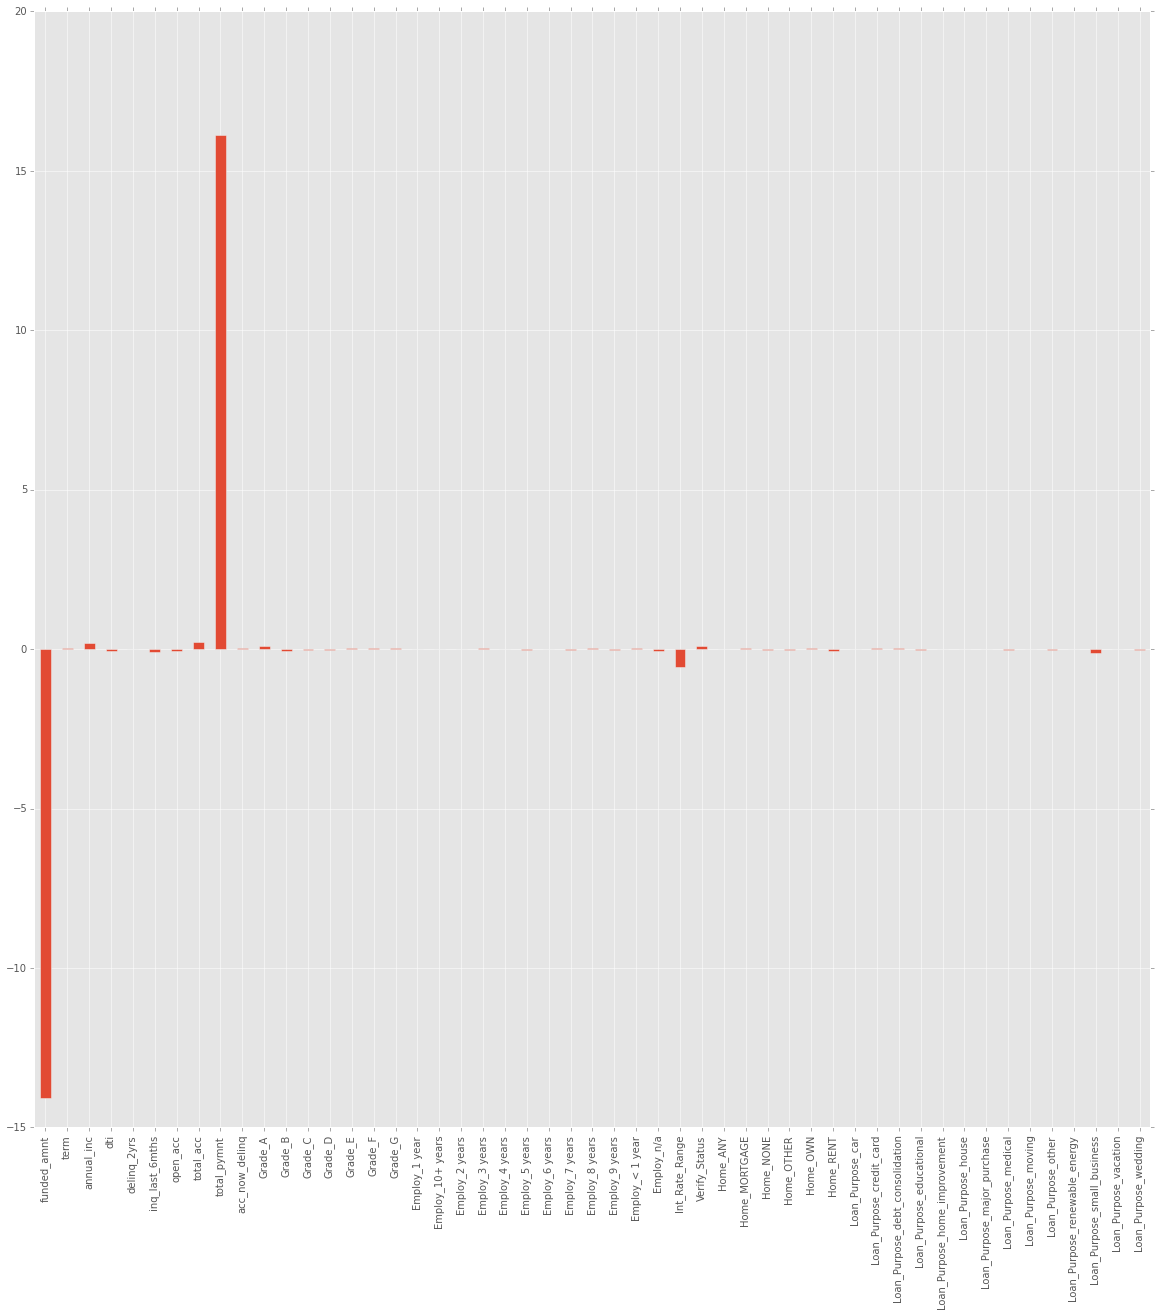

In [9]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))

weights = pd.Series(updated_logreg_obj.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar')
plt.show()

### Support Vector Machines

We continue our trials by observing the Support Vector Machines (SVM) to see if this method of classification can classify our data set better than logistic regression. We will start by observing the SVM of our original data set. Although it will most likely turn out the same way, not giving very good data, the SVM may reveal new splits in the decision. We will follow that up with looking at the SVM of the reduced data set that contains the completed loans. We can compare the accuracy of the SVM with the above logistic regression to determine if one classifies this data better than the other.

Note: We use the SGDClassifier due to the size of our data set. Both sets are large and would take too long to train with a normal SVM in a time that is reasonable.

SVM: 0.930982217314
Confusion Matrix:
[[     0  12249]
 [     0 165227]]
Coefficients [[ -1.46627926e-02   3.04139619e-03   2.43414607e-02   3.57455177e-03
    4.86850881e-04  -5.24762615e-03   2.10314660e-03  -1.89346059e-03
    2.74425762e-02   1.48390617e-05   1.22251648e-01   1.25253197e-02
   -7.04822669e-02  -4.45894810e-02  -1.21294288e-02  -3.83122670e-03
    4.89102548e-03  -2.43985673e-06   6.80142891e-04   3.09352320e-04
   -2.36784619e-04   6.60337914e-05  -3.82077252e-04  -9.11074015e-04
   -7.38167234e-04   1.73780314e-04   8.50581102e-05  -3.00920018e-04
    5.38906802e-04  -8.62642214e-02  -7.31908254e-05   8.33631660e-04
    4.86025153e-04  -2.37895545e-05  -1.11465167e-03   1.16996784e-03
   -1.17585882e-03   2.21469141e-04   1.81397563e-03  -6.57811155e-04
   -2.74677858e-03   1.89438833e-04   8.91828246e-05   1.57003037e-04
   -6.46735126e-04  -1.16489742e-04  -7.29701310e-04   1.13948811e-04
   -1.88371831e-03  -3.04539408e-06  -9.32014083e-04]]


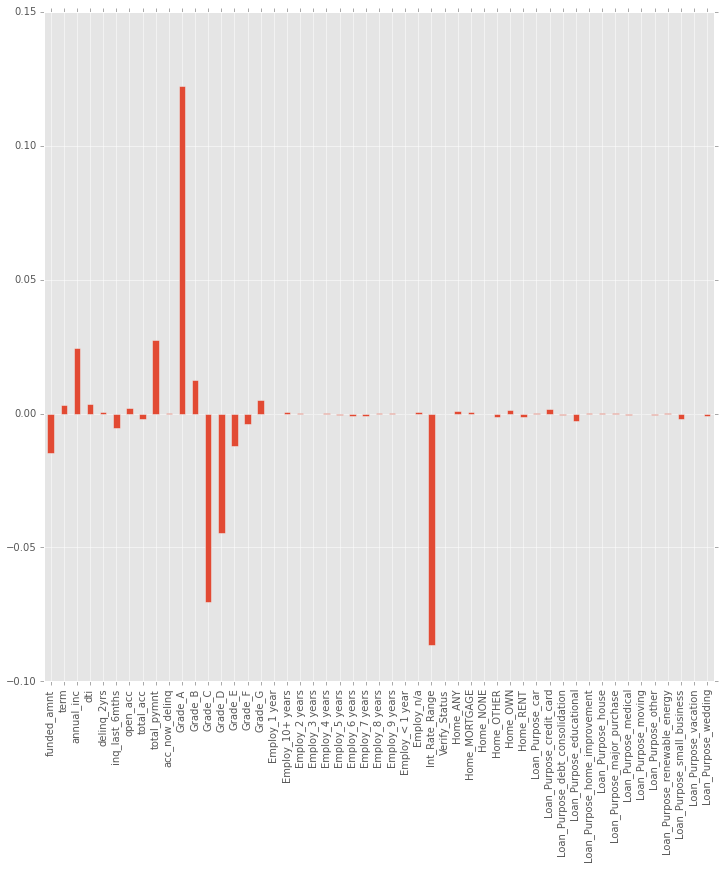

In [10]:
# SVM of full data set
warnings.simplefilter("ignore")

# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

# Get SVM classifier
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

# Fit our data (after it is scaled) to an SVM classification
scl = StandardScaler()
for train_idx, test_idx in cv_obj:
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print 'SVM:', acc
print 'Confusion Matrix:\n', conf
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(12,12))

The accuracy of the full data set remained very similar. It stayed at around 93% accuracy, but still has the same style of confusion matrix from the logistic regression with bad loans being classified as good ones. We now look at the SVM of the reduced data to see how it performs.

SVM: 0.867898408948
Confusion Matrix:
[[ 5119  7122]
 [   35 41902]]
Coefficients [[ -7.94948816e-01  -4.61283377e-02  -5.77258297e-03  -2.05544228e-02
   -4.65146383e-03  -3.17515664e-03  -9.78413180e-03   1.53654141e-02
    9.36007125e-01   1.39870000e-03   2.54798039e-03   8.82887645e-03
    8.68104807e-03   2.95518255e-03  -1.25396377e-02  -2.67800360e-02
   -1.70751992e-02   3.84106318e-04   2.54657576e-03   1.84506535e-03
    2.59689714e-04  -1.14557588e-03  -1.98445622e-03  -1.37607298e-03
   -7.77228896e-04   4.01201820e-04  -1.09905532e-03   6.63953041e-04
   -3.29755491e-03  -4.62956315e-02  -9.57230928e-03   4.30522204e-03
    1.61522963e-03   7.43978465e-04  -2.45787185e-04   2.69643151e-03
   -3.20676600e-03   5.43135228e-03  -3.73055144e-03  -5.01172915e-03
    1.63153756e-04   3.74627246e-03   2.27999828e-03   3.58469422e-03
    2.87404619e-03   3.06069672e-03   7.22920742e-03   9.92576559e-04
   -7.57857638e-03   4.90010862e-03   4.67251841e-04]]


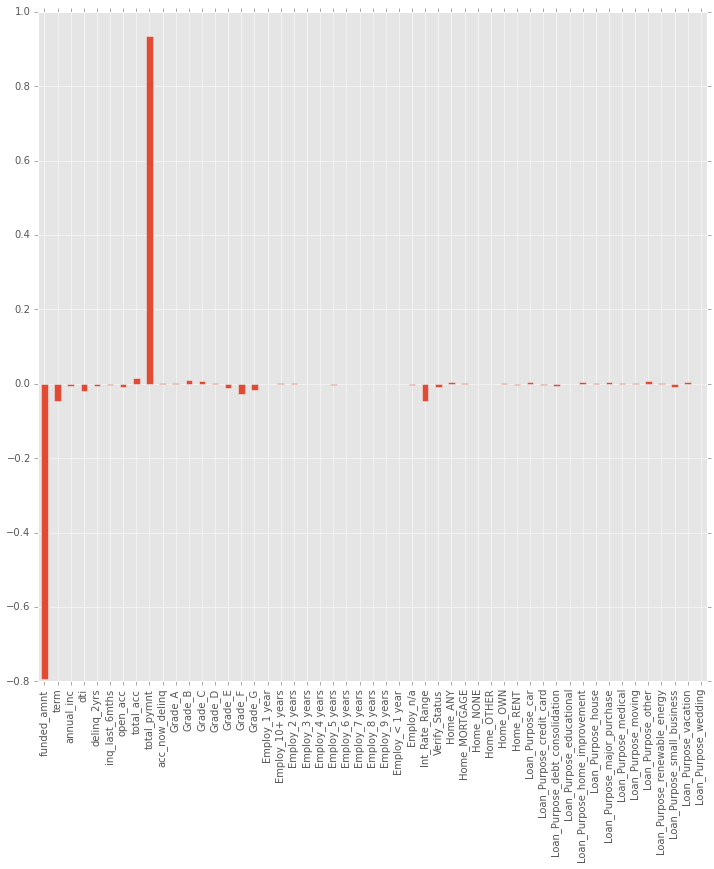

In [11]:
# SVM of completed loan data set
# SGDClassifier using 'hinge' for loss to get an SVM
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'SVM:', acc
print 'Confusion Matrix:\n', conf
print 'Coefficients', svm_sgd.coef_
weights = pd.Series(svm_sgd.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar', figsize=(12,12))

The SVM for the reduced data, which includes just completed loans, has a much lower accuracy than the logistic regression classification of the same data. The accuracy dropped from just below 98.0% to around 86.8%. This is a significant difference. It is possible that part of this is due to SGDClassifier taking the Stochastic Gradient instead of the full gradient of the SVM. Although the SGD runs faster than the linear regression model we used (LinearRegression()), it does not have the accuracy that we would expect or want in this situation, especially when the original data stayed around the same accuracy between the two different classifications.

It is interesting to note that the classes that the SVM pulls out are almost identical to the ones the logistic regression uses. Funded amount and total payment are still at the top of the list with Interest Rate Range being a distant fourth, but still near the top. Surprisingly, it has added importance on the 'Term' variable that the logistic regression did not pull out.

### Additional Analysis: Are there better variable choices?

In this section, we will use the logistic regression classification, which seemed to perform better for our reduced data set, to see if we can increase the accuracy of our model by looking at different variable inputs. The idea is to reduce the number of inputs to try and improve the data. What if we look at our major regression factors and limit our dataset to those factors? Do we improve accuracy any by limiting the data given to the classifier?

In [12]:
used_temp_df = pd.DataFrame()
major_factors_df = loan_df_finished

for col in ['funded_amnt', 'Int_Rate_Range', 'total_pymnt', 'annual_inc', 'Verify_Status']:
    if col in major_factors_df:
        used_temp_df[col] = major_factors_df[col]
        
updated_X = used_temp_df.values

updated_logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

Index([u'funded_amnt', u'Int_Rate_Range', u'total_pymnt', u'annual_inc',
       u'Verify_Status'],
      dtype='object')
====Iteration 0  ====
accuracy 0.981062423862
confusion matrix
[[11254   944]
 [   82 41898]]
====Iteration 1  ====
accuracy 0.980637897301
confusion matrix
[[11102   986]
 [   63 42027]]
====Iteration 2  ====
accuracy 0.981689984865
confusion matrix
[[11386   915]
 [   77 41800]]
====Iteration 3  ====
accuracy 0.980637897301
confusion matrix
[[11361   971]
 [   78 41768]]
====Iteration 4  ====
accuracy 0.981191627598
confusion matrix
[[11345   948]
 [   71 41814]]


accuracy: 0.978847502676
[[11221  1072]
 [   74 41811]]


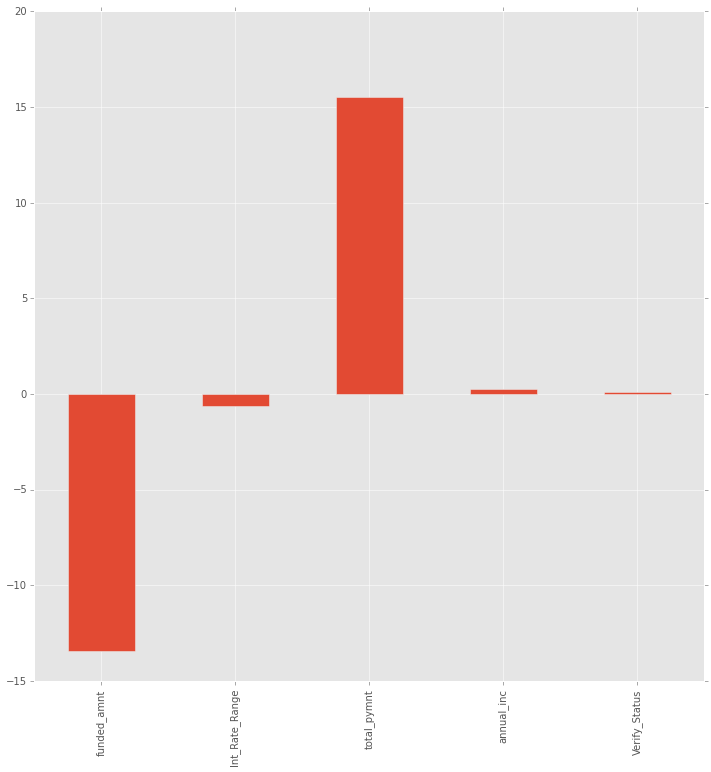

In [15]:
scl = StandardScaler()
scl.fit(updated_X[train_indices])

X_train_scaled = scl.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scl.transform(updated_X[test_indices])

# Fit the regression to the new scaled data
updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

# Rescore the accuracy and confusion matrix for the scaled data
acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf
weights = pd.Series(updated_logreg_obj.coef_[0],index=used_temp_df.columns)
weights.plot(kind='bar', figsize=(12,12))

The unscaled data of this significantly reduced data set has a marginally better fit than the original reduced data set. If you compare the 98.1% average of the newly reduced data set to the 97.9% of the base reduced data, you get a slightly better performance by taking out some of the less important, according to the logistic regression, variables. The scaled data comes in at a similar accuracy rating of the original sample at 97.9% so there really is not a huge change here. Even looking at the weights of each, the funded amount and total payment factors still far outweigh the others.